# Preamble

+ After opening this notebook, tun these cells before anything else, to import libraries and define functions.

+ This notebook requires the following packages, which are pre-installed on Google Colab.

    + Python 3
    + NumPy
    + SciPy
    + Matplotlib

In [38]:
## Preamble / required packages
import numpy as np
import scipy
np.random.seed(0)

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline
## default first plot color is black
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['k'])  # Set default plot color to black
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)  # Reset to default colors


## Disable warnings
import warnings
warnings.filterwarnings('ignore')

# !apt-get install nvidia-cuda-toolkit
# !pip3 install numba
## These lines allow Google Colab to import and work with external files.
# %rm -rf illotka
# !git clone https://github.com/williamgilpin/illotka.git
# %cd illotka
# import importlib.util, sys
# module_path = "/content/illotka/base.py"
# spec = importlib.util.spec_from_file_location("base", module_path)
# base = importlib.util.module_from_spec(spec)
# sys.modules["base"] = base
# spec.loader.exec_module(base)


from base import *
from utils import *

# Autoreload
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Revisiting stability vs. complexity


## The generalized Lotka-Volterra model

We consider random ecosystems given by the generalized Lotka-Volterra equation,

$$
    \frac{dN_i}{dt} = N_i \left( r_i + \sum_{j=1}^N A_{ij} N_j \right)
$$

where $N_i$ is the population of species $i$, $r_i$ is the intrinsic growth rate of species $i$, and $A_{ij}$ is the interaction coefficient between species $i$ and $j$.

To study the behavior of this model, we consider the case where $r_i \sim \mathcal{N}(0,1)$, and the matrix $A$ has the form 

$$
    A = Q - d\, I
$$
where $I \in \mathbb{R}^{N \times N}$ is the identity matrix, $Q_{ij} \sim \mathcal{N}(0,1)$ and $d$ is a constant density-limitation.




(0.0, 0.531616527165715)

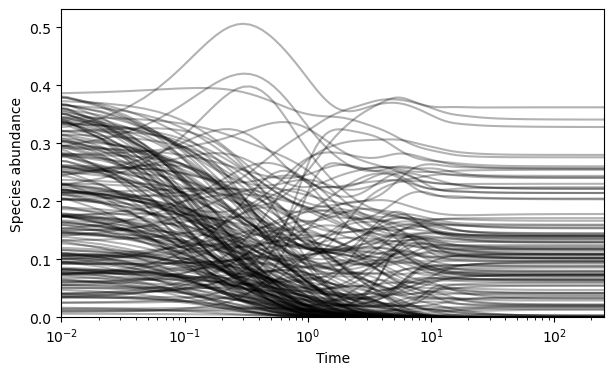

In [26]:
# Set the simulation parameters
tmax = 20000 # Maximum integration duration
n = 200 # Number of species
d = 12.5 # Density-limitation

## Initialize the model
eq = GaussianLotkaVolterra(n)
eq.A = np.random.normal(size=(n, n)) - d * np.identity(n)
eq.r = np.random.normal(size=n)

## Initial conditions
ic = 0.4 *np.random.uniform(size=n)

## Numerically integrate the model
t, y = eq.integrate(tmax, ic)

plt.figure(figsize=(7, 4))
plt.semilogx(t, y, color="k", lw=1.5, alpha=0.3);
plt.xlabel("Time")
plt.ylabel("Species abundance")
plt.xlim(1e-2, np.max(t))
plt.ylim(0, None)



### How many species survive?

In [27]:
nonzero_remaining = np.sum(y[-1] > 1e-12) # Precision floor
print(f"{nonzero_remaining} species out of {n} remain")

106 species out of 200 remain


## We repeat the experiment many times

[################### ] 



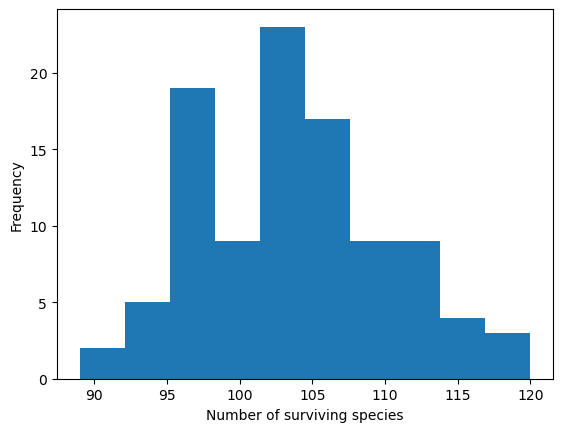

In [28]:
n_replicates = 100
tmax = 1000
number_survive = []
for i in range(100):
    progress_bar(i, n_replicates) # Print progress bar for loop

    eq = GaussianLotkaVolterra(n)
    eq.A = np.random.normal(size=(n, n)) - d * np.identity(n)
    # eq.A = eq.A * np.identity(n) # Wipe out all off-diagonal elements
    eq.r = np.random.normal(size=n)
    t, y = eq.integrate(tmax, ic)

    n_survive = np.sum(y[-1] > 1e-12)
    number_survive.append(n_survive)

plt.hist(number_survive)
plt.xlabel("Number of surviving species");
plt.ylabel("Frequency");


In [31]:
print(np.mean(number_survive))
print(np.std(number_survive))

103.66
6.259744403727679


In [32]:
print(0.5 * n)
print(np.sqrt(n * 0.5 * (1 - 0.5)))

100.0
7.0710678118654755


### Properties of the Random Lotka-Volterra model

Proven in [Serván et al. 2018](https://www.nature.com/articles/s41559-018-0603-6).

1. On average, half of all species survive at steady-state. Across replicates, the number of surviving species follows a binomial distribution with mean $n/2$.
2. For a given matrix $A$, the steady-state solution is unique (global attractor).
3. For a given matrix $A$, there always exists a density-limitation $d$ that that leads to a single stable steady-state.

Main assumption: Interactions and growth rates are drawn from a symmetric distribution with finite variance.


In [311]:
# from scipy.stats import truncnorm
# def normal_truncated(size, mu=0, sigma=9, clip=1):
#     """
#     Sample from a truncated normal distribution.

#     Args:
#         size: The number of samples to draw.
#         mu: The mean of the normal distribution.
#         sigma: The standard deviation of the normal distribution.
#         clip: The truncation point.

#     Returns:
#         The samples from the truncated normal distribution.
#     """
#     a, b = -clip, clip
#     samples = truncnorm.rvs(a, b, loc=mu, scale=sigma, size=size)
#     samples /= np.std(samples)
#     return samples


# from scipy.stats import gennorm
# # beta = 4.0      # shape parameter; β = 2 ⇒ Gaussian; β > 2 ⇒ super‐Gaussian (thin‐tailed)
# # scale = 1.0     # analogous to σ in the normal
# # samples_gennorm = gennorm.rvs(beta, loc=0, scale=scale, size=n_samples)


# def normal_generalized(size, mu=0, sigma=1, beta=1):
#     """
#     Sample from a generalized normal distribution.

#     Args:
#         size: The number of samples to draw.
#         mu: The mean of the distribution.
#         sigma: The standard deviation of the distribution.
#         beta: The shape parameter of the distribution.

#     Returns:
#         The samples from the generalized normal distribution.
#     """
#     samples = gennorm.rvs(beta, loc=mu, scale=sigma, size=size)
#     samples /= np.std(samples)
#     return samples




The generalized normal distribution is parametrized by shape parameter $\beta$, which controls the tail thickness. It is given by

$$
    p(x) = \frac{\beta}{2\sigma\Gamma(1/\beta)} e^{-\left(\frac{|x-\mu|}{\sigma}\right)^\beta}
$$

+ when $\beta < 1$, the distribution has fatter tails than the normal distribution.
+ when $\beta > 1$, the distribution has lighter tails than the normal distribution.


In [33]:

# def normal_generalized(size, mu=0, sigma=1, beta=0.1):
#     """
#     Sample from a generalized normal distribution.

#     Args:
#         size: The number of samples to draw.
#         mu: The mean of the distribution.
#         sigma: The standard deviation of the distribution.
#         beta: The shape parameter of the distribution.

#     Returns:
#         The samples from the generalized normal distribution.
#     """
#     samples = gennorm.rvs(beta, loc=mu, scale=sigma, size=size)
#     samples /= np.std(samples)
#     return samples


163 species out of 300 remain


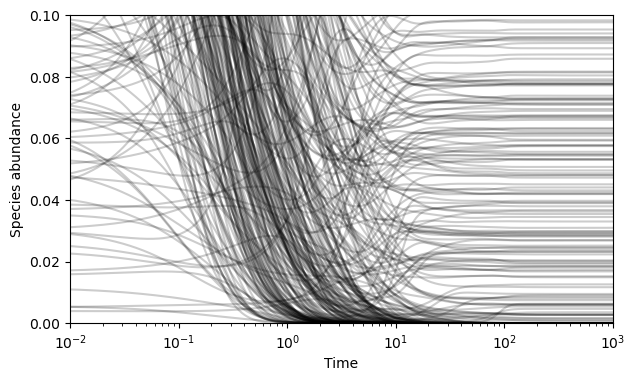

In [128]:
# Set the simulation parameters
tmax = 10000 # Maximum integration duration
n = 300 # Number of species
d = 18 # Density-limitation
seed = 0 # Seed for random number generator
# seed = None

## Initialize the model
np.random.seed(seed)
eq = GaussianLotkaVolterra(n, random_state=seed, tolerance=1e-10)


eq.A = np.random.normal(size=(n, n)) - d * np.identity(n)
eq.r = np.random.normal(size=n)

# eq.A = 1.5 * normal_generalized(size=(n, n)) - d * np.identity(n)
# eq.r = normal_generalized(size=n)


# print(np.linalg.cond(eq.A + d * np.identity(n)))
# print(np.linalg.cond(eq.A))


## Initial conditions
ic = 0.5 * np.random.uniform(size=n)

## Numerically integrate the model
t, y = eq.integrate(tmax, ic)

plt.figure(figsize=(7, 4))
plt.semilogx(t, y, color="k", lw=1.5, alpha=0.2);
plt.xlabel("Time")
plt.ylabel("Species abundance")
plt.xlim(1e-2, 1000)
plt.ylim(0, 0.1)


nonzero_remaining = np.sum(y[-1] > 1e-12) # Precision floor
print(f"{nonzero_remaining} species out of {n} remain")

## How long does it take to reach the steady-state?

Given a steady-state solution $\mathbf{N}^*$, the *settling time* is the time it takes for the solution to reach a given tolerance $\epsilon$ of the steady-state.

$$
    \argmin_{t} \bigg( \dfrac{\| \mathbf{N}(t) - \mathbf{N}^* \|}{\| \mathbf{N}(t) \|} < \epsilon \bigg)
$$




In [144]:
def compute_settling_time(traj, tvals=None, eps=1e-6):
    """
    Compute the settling time from a multivariate time series. 
    If the trajectory does not reach the steady-state within the integration time, 
    return a NaN.
    """
    final_value = traj[-1]
    scaled_distance = (np.linalg.norm(traj - final_value, axis=1)) / np.linalg.norm(traj, axis=1)
    final_index = np.where(scaled_distance < eps)[0]
    if len(final_index) == 0:
        return np.nan
    else:
        return final_index[0]




10000

# Hierarchical structure in the Lotka-Volterra model


$$
    A = P^\top (A^{(0)} - d\, I) P + \epsilon \, E,
$$


+ As before,$A^{(0)}_{ij},  r_i \sim \mathcal{N}(0, 1)$


+ $P \in \mathbb{R}^{N \times N}$ is a low-rank assigment matrix describing functional redundancy or trophic levels among species. 

+ $E \in \mathbb{R}^{N \times N}$ is a matrix of random noise that prevents exact redundancy.
+ $\epsilon \ll 1$ is a small constant that controls the degree to which redundant species deviate from exact redundancy.

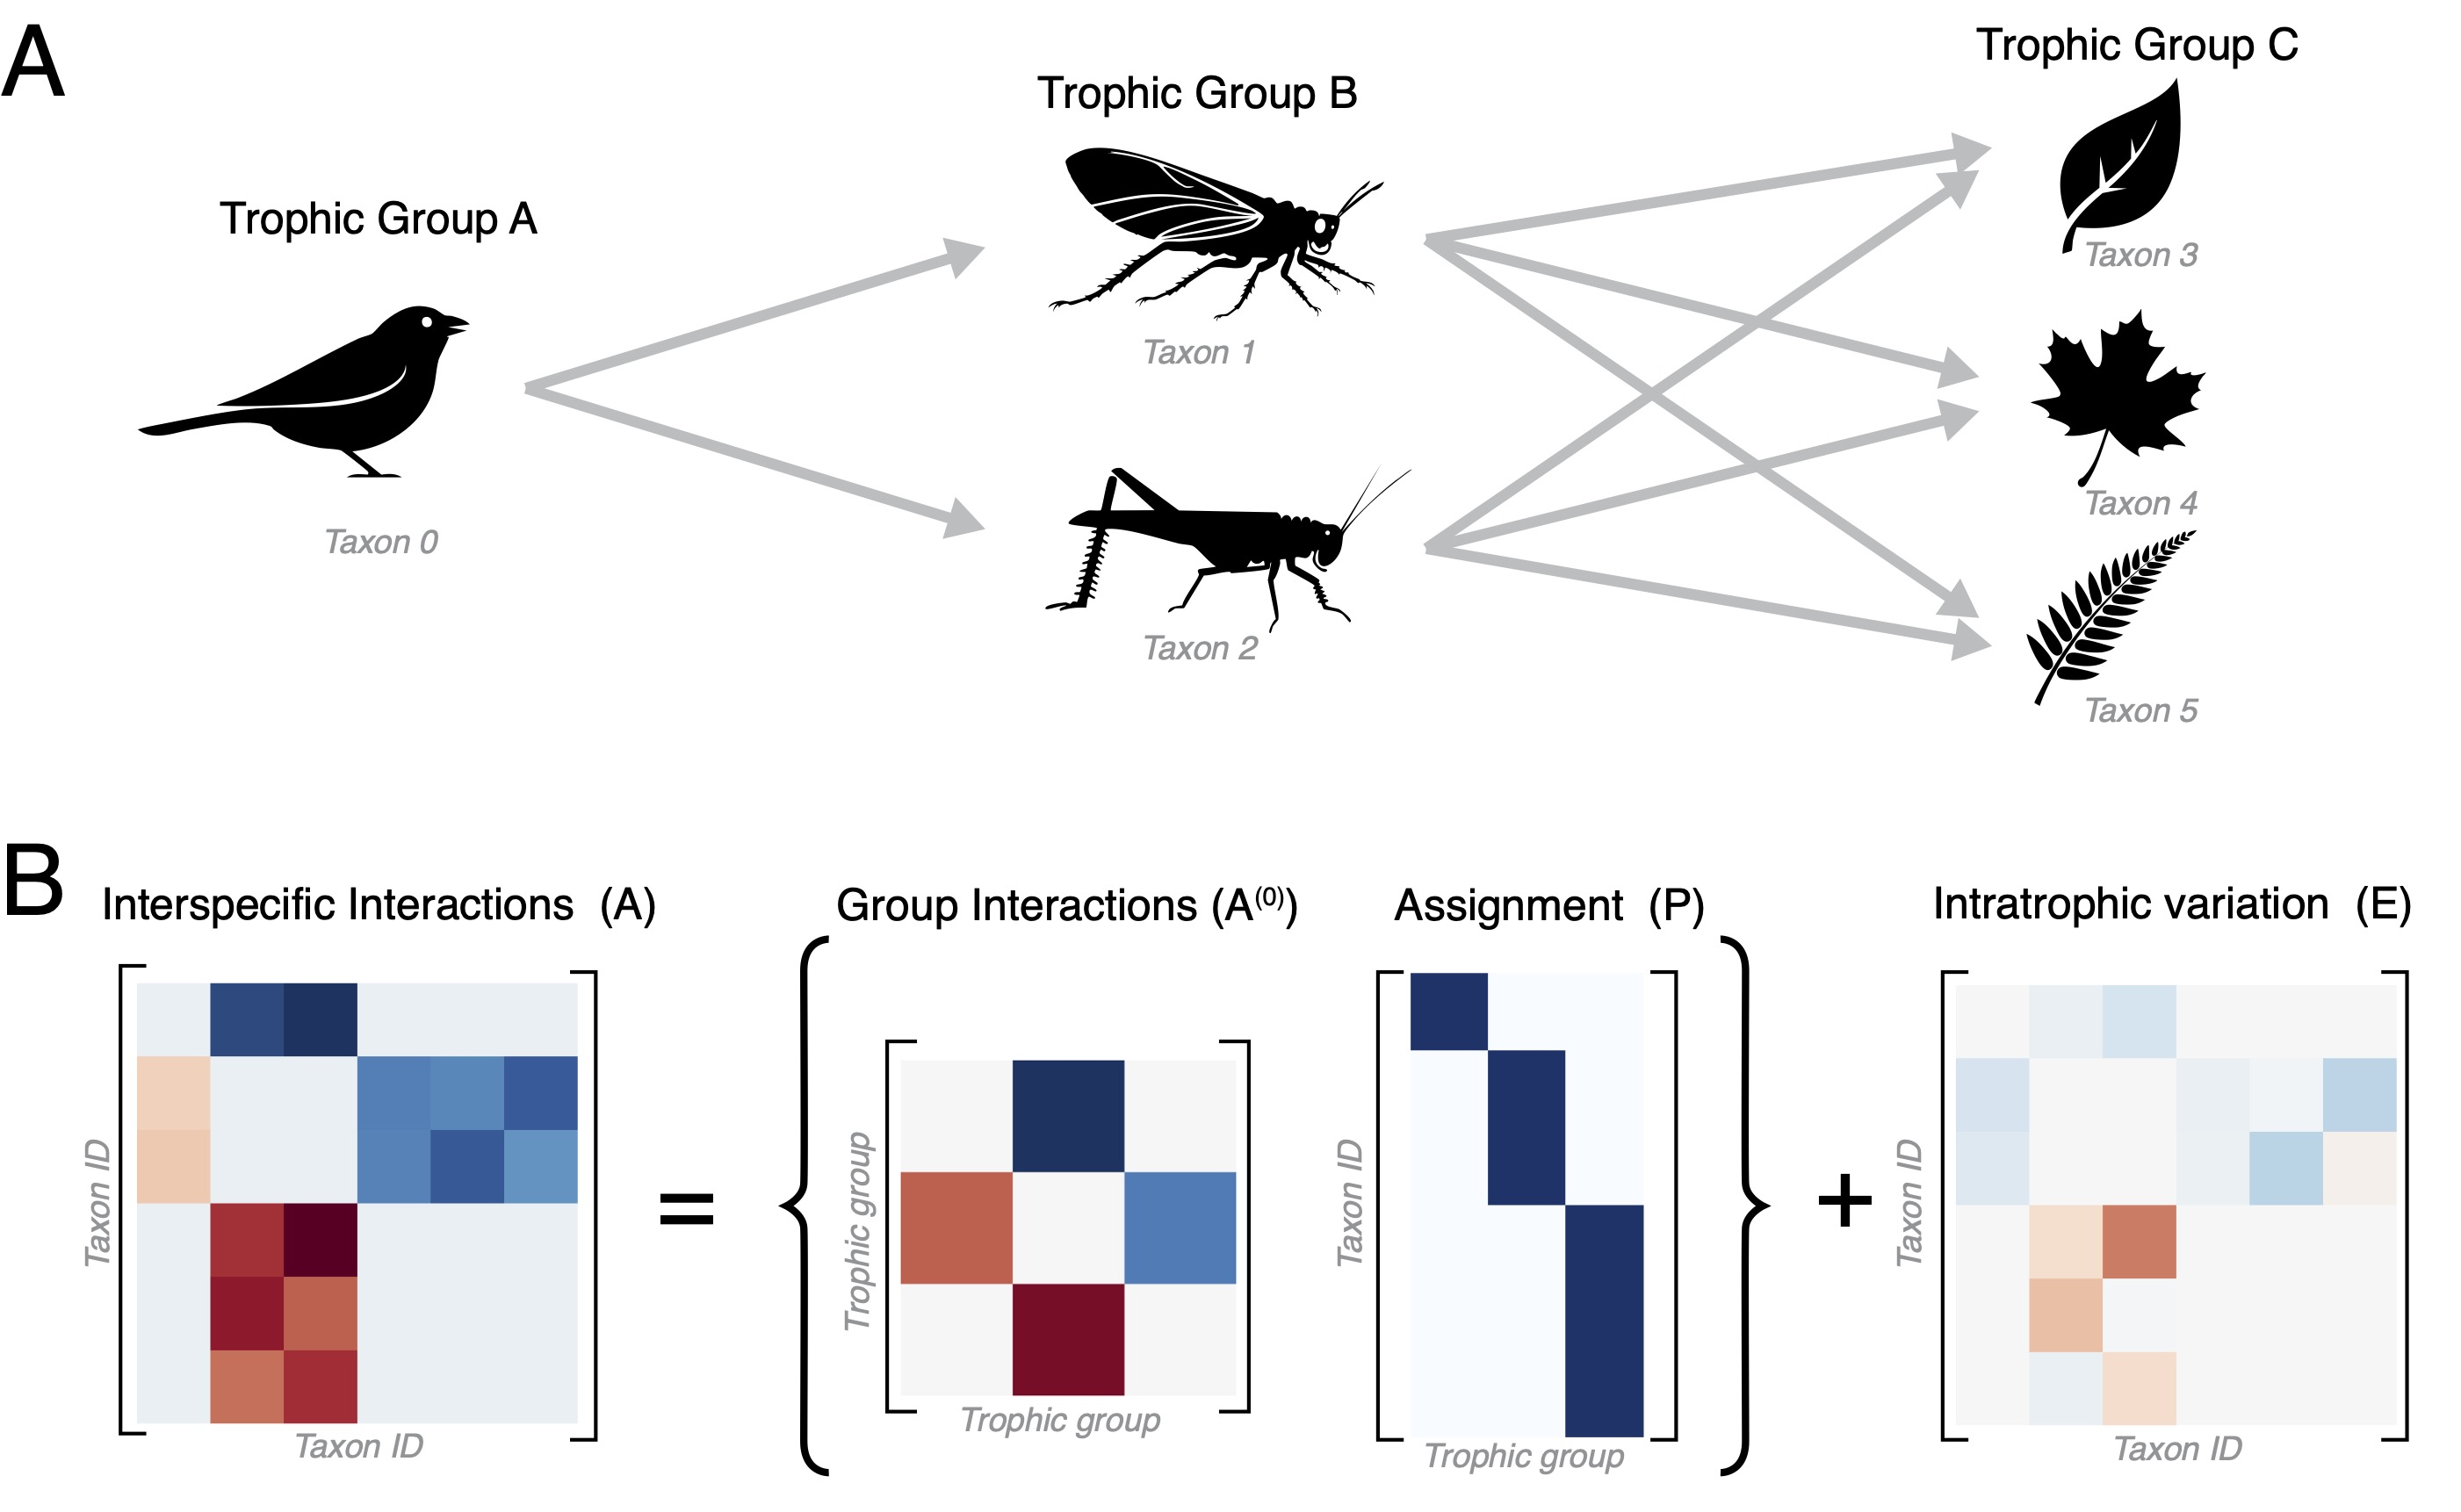

In [924]:
from IPython.display import IFrame, HTML, display, Image

## Loads a figure from the resources folder
Image("./resources/fig_model.jpg", width=1200)

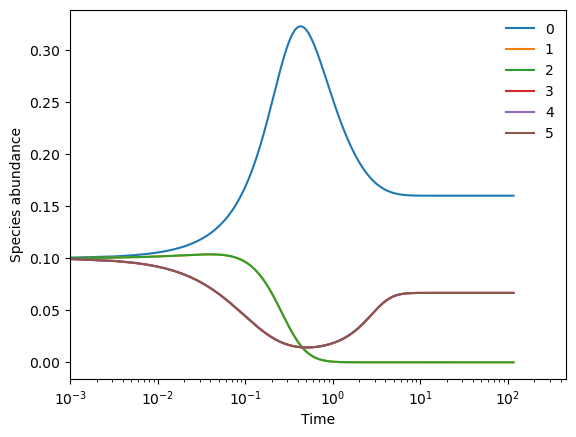

In [1048]:
m_trophs = 3
n_species = 6

p_mat = np.array(
    [[1, 0, 0, 0, 0, 0],
     [0, 1, 1, 0, 0, 0],
     [0, 0, 0, 1, 1, 1]]
)

interactions_trophic = np.array([
    [0, 0.5, 0],
    [-0.5, 0, 0.3],
    [0, -0.8, 0],
])*50



eq = RandomLotkaVolterra(n_species)
eq.r = np.array([0.8, 0.9, 1]) @ p_mat
eq.A = p_mat.T @ (interactions_trophic - 5*np.identity(m_trophs)) @ p_mat #+ 1e-6 * np.random.normal(size=(n_species, n_species))

ic = np.ones(n_species) * 0.1
t, y = eq.integrate(tmax, ic)

plt.semilogx(t, y);
plt.legend(np.arange(n_species), frameon=False);
plt.xlim(1e-3, None);
plt.xlabel("Time");
plt.ylabel("Species abundance");


## Now, let's scale up

Instead of imposing a specific functional redundancy, we'll sample from a distribution of functional redundancies by sampling $P$ from a family of low-rank matrices.

(0.001, np.float64(144086.50812308563))

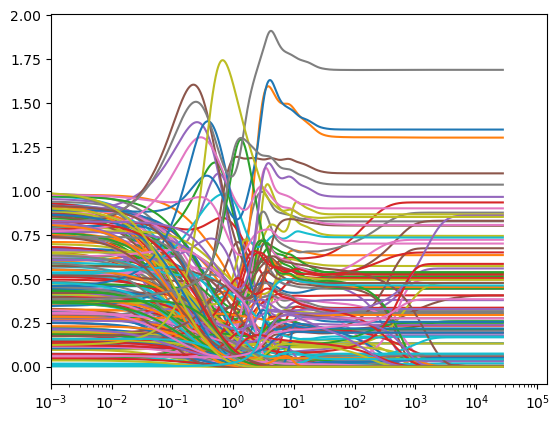

In [158]:
tmax = 1e8
n_val = 200

ic = np.random.uniform(size=n_val)
eq = RandomLotkaVolterra(n_species=200, eps=1e-3)
t, y = eq.integrate(tmax, ic)
plt.semilogx(t, y);
plt.xlim(1e-3, None)

eps: 1e-05
eps: 3.5938136638046256e-05
eps: 0.0001291549665014884
eps: 0.0004641588833612782
eps: 0.0016681005372000592
eps: 0.005994842503189409
eps: 0.021544346900318846
eps: 0.07742636826811278
eps: 0.2782559402207126
eps: 1.0


Text(0, 0.5, 'Settling Time')

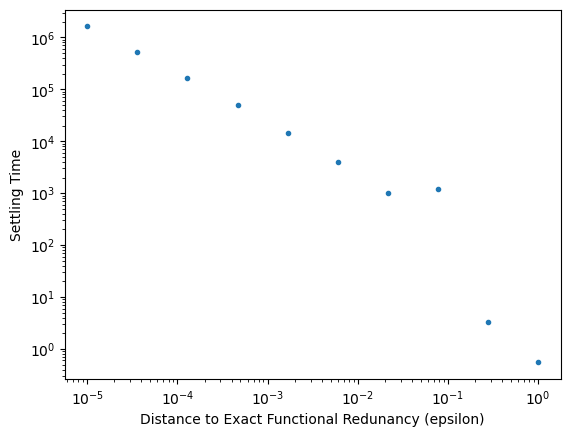

In [159]:

tmax = 1e8

n_val = 200
ic = np.random.uniform(size=n_val)
settling_times = []
eps_vals = np.logspace(-5, 0, 10)
for eps in eps_vals:
    print(f"eps: {eps}")
    eq = RandomLotkaVolterra(n_val, random_state=0, eps=eps,  sigma=2.0, d=4.5, kfrac=0.2, connectivity=0.05)
    t, y = eq.integrate(tmax, ic)
    tind = compute_settling_time(y)
    settling_times.append(t[tind])


plt.loglog(eps_vals, settling_times, '.')
plt.xlabel("Distance to Exact Functional Redunancy (epsilon)")
plt.ylabel("Settling Time")

# The Lotka-Volterra model as analogue linear regression

+ Without the outer term, the Lotka-Volterra model is a linear time-invariant system. 

+ The solution to the Lotka-Volterra model is the solution to the linear system $A \mathbf{N}^* = -\mathbf{r}$.

+ The outer term adds a positivity constraint. In practice, this leads to sparsity (exclusion) in the steady-state solution $\mathbf{N}^*$.


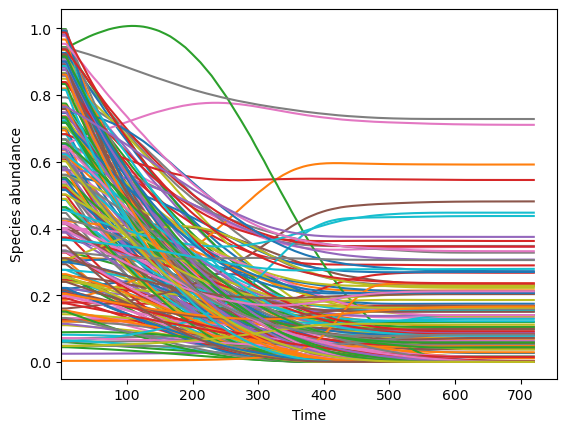

In [161]:
eq = RandomLotkaVolterra(n_val, random_state=3, eps=1e0, sigma=0.5, d=4.5, kfrac=0.0, connectivity=0.05)
ic = np.random.uniform(size=n_val)
t, y = eq.integrate(tmax, ic, tol=1e-10)
plt.plot(y);
plt.xlim(1e-3, None)
plt.xlabel("Time")
plt.ylabel("Species abundance")
plt.show()


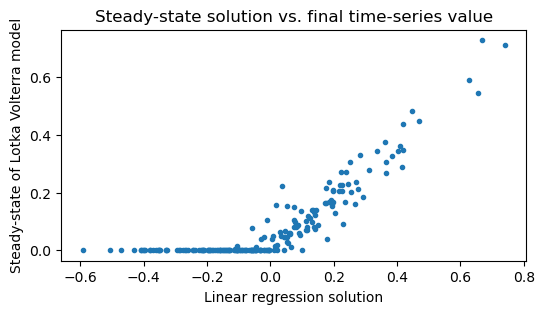

Text(0.5, 1.0, 'Correlation: 0.81')

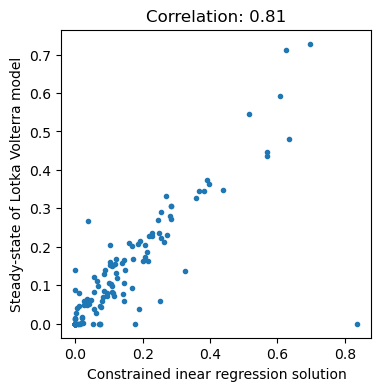

In [162]:
## Perform unconstrained linear regression
plt.figure(figsize=(6, 3))
plt.plot(np.linalg.solve(eq.A, -eq.r), y[-1], '.')
plt.xlabel("Linear regression solution")
plt.ylabel("Steady-state of Lotka Volterra model")
plt.title("Steady-state solution vs. final time-series value")
plt.show()

## Perform constrained linear regression
from scipy.optimize import nnls, lsq_linear
sol_nnls = lsq_linear(eq.A, -eq.r, bounds=(0, np.inf), tol=1e-10).x
plt.figure(figsize=(4, 4))
plt.plot(sol_nnls, y[-1], '.')
plt.xlabel("Constrained inear regression solution")
plt.ylabel("Steady-state of Lotka Volterra model")
from scipy.stats import spearmanr
corr = spearmanr(sol_nnls, y[-1])
plt.title(f"Correlation: {corr.correlation:.2f}")





# What sets the hardness of linear regression?


We can write a linear regression system of the form $A \mathbf{N} = -\mathbf{r}$ in terms of column vectors of $A$ and $\mathbf{r}$.

If 
$$
    A = \begin{bmatrix}
        \mathbf{a}_1 & \mathbf{a}_2 & \cdots & \mathbf{a}_N
    \end{bmatrix}
$$

Then we seek a solution to

$$
    \mathbf{a}_1 N_1 + \mathbf{a}_2 N_2 + \cdots + \mathbf{a}_N N_N = -\mathbf{r}
$$

If we use gradient descent to solve this system, we can write the update rule as

$$
    N_i \leftarrow N_i - \eta \left( \sum_{j=1}^N a_{ij} N_j + r_i \right)
$$

Condition: two row-vector products are very close


### Functional reduncancy *is* ill conditioning

+ Unlike $\epsilon$, which is a property of our particular model for generating interaction matrices $A$, the condition number is a property we can measure from *any* interaction $A$.

+ Two nearly-parallel rows of $A$ is equivalent to two species being nearly-redundant (interchangeable in the community).

Text(0, 0.5, 'Condition Number')

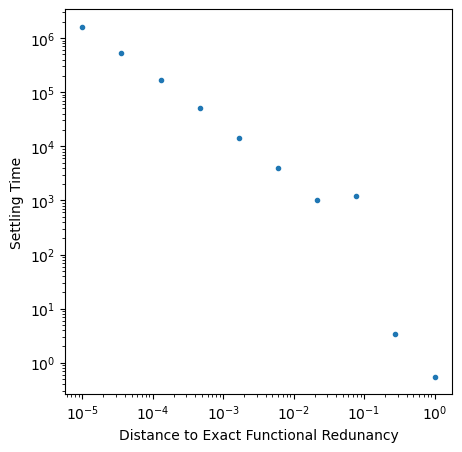

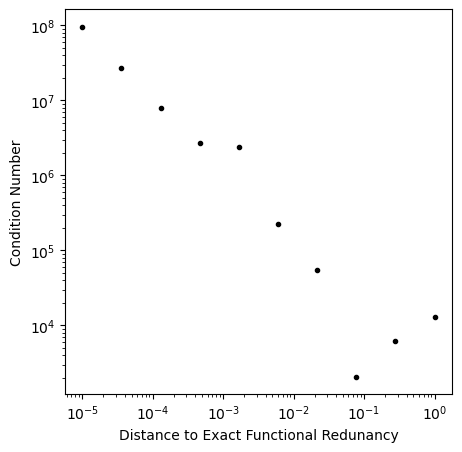

In [ ]:
tmax = 1e8

n_val = 200
ic = np.random.uniform(size=n_val)
settling_times = []
eps_vals = np.logspace(-5, 0, 10)
condition_numbers = []
for eps in eps_vals:
    print(f"eps: {eps}")
    eq = RandomLotkaVolterra(n_val, random_state=0, eps=eps,  sigma=2.0, d=4.5, kfrac=0.2, connectivity=0.05)
    t, y = eq.integrate(tmax, ic)
    tind = compute_settling_time(y)
    settling_times.append(t[tind])
    condition_numbers.append(np.linalg.cond(eq.A))


plt.figure(figsize=(5, 5))
plt.loglog(eps_vals, settling_times, '.')
plt.xlabel("Distance to Exact Functional Redunancy")
plt.ylabel("Settling Time")

plt.figure(figsize=(5, 5))
plt.loglog(eps_vals, condition_numbers, '.k')
plt.xlabel("Distance to Exact Functional Redunancy")
plt.ylabel("Condition Number")



In [ ]:
tmax = 1e8

n_val = 200
ic = np.random.uniform(size=n_val)
settling_times = []
eps_vals = np.logspace(-5, 0, 10)
condition_numbers = []
seed = None
for _ in range(10):
    print(f"eps: {eps}")
    # eq = RandomLotkaVolterra(n_val, random_state=0, eps=eps,  sigma=2.0, d=4.5, kfrac=0.2, connectivity=0.05)
    eq = GaussianLotkaVolterra(n_val, random_state=seed, tolerance=1e-10)
    eq.A = 1.5 * normal_generalized(size=(n_val, n_val)) - d * np.identity(n_val)
    eq.r = normal_generalized(size=n_val)
    t, y = eq.integrate(tmax, ic)
    tind = compute_settling_time(y)
    settling_times.append(t[tind])
    condition_numbers.append(np.linalg.cond(eq.A))

plt.loglog(condition_numbers, settling_times, '.')
plt.xlabel("Condition Number")
plt.ylabel("Settling Time")


eps: 1.0
eps: 1.0
eps: 1.0
eps: 1.0
eps: 1.0
eps: 1.0
eps: 1.0


In [ ]:
d = 18 # Density-limitation
seed = 0 # Seed for random number generator
# seed = None

## Initialize the model
np.random.seed(seed)
eq = GaussianLotkaVolterra(n, random_state=seed, tolerance=1e-10)


eq.A = np.random.normal(size=(n, n)) - d * np.identity(n)
eq.r = np.random.normal(size=n)

# eq.A = 1.5 * normal_generalized(size=(n, n)) - d * np.identity(n)
# eq.r = normal_generalized(size=n)

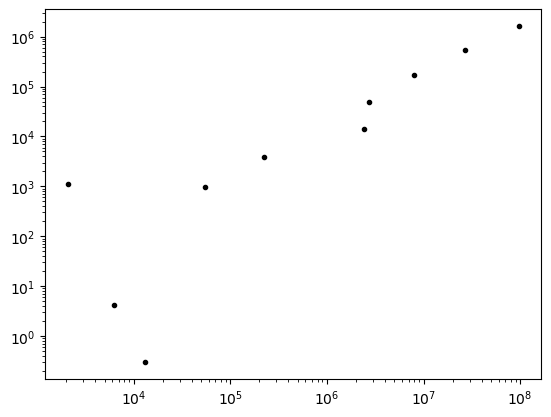

In [165]:
plt.loglog(condition_numbers, settling_times, '.k')

# Krylov bound on linear solvers

The Krylov bound on linear solvers expresses the convergence time in terms of the condition number of the matrix.

$$
    \tau = 
$$



# How does the settling time depend on the number of species?







In [76]:

n_vals = np.unique(np.logspace(1, 4, 200).astype(int)) # Range of species numbers to consider
tmax = 20000 # Maximum integration time
d = 21.5 # Density-limitation


## Loop over species numbers and compute the settling time for each
all_t = []
all_y = []
settling_times = []
for i,n in enumerate(n_vals):
    progress_bar(i, len(n_vals))

    eq = GaussianLotkaVolterra(n)
    eq.A = np.random.normal(size=(n, n)) - d * np.identity(n)
    eq.r = np.random.normal(size=n)
    ic = np.random.uniform(size=n)
    t, y = eq.integrate(tmax, ic)
    all_t.append(t.copy())
    all_y.append(y.copy())
    
    tind = compute_settling_time(y)
    if not np.isnan(tind):
        settling_times.append(t[tind])
    else:
        settling_times.append(np.nan)


[################### ] 



(10.0, np.float64(1602.7528342389994))

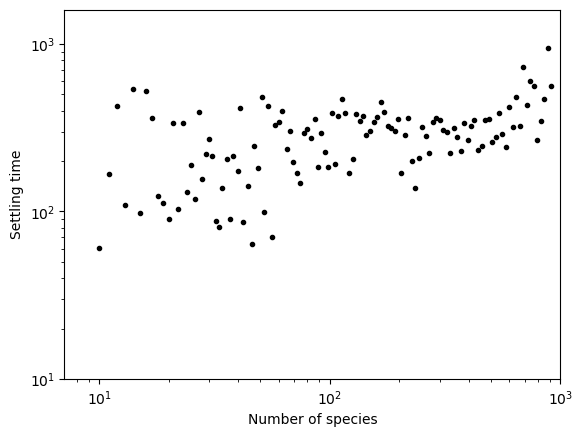

In [79]:
plt.loglog(n_vals, settling_times, '.k')
plt.xlabel("Number of species")
plt.ylabel("Settling time")
plt.xlim(None, 1000)
plt.ylim(1e1, None)

# Supertransients

+ Chimeras in the Kuramoto model
+ Pipe turbulence
+ Couple map lattices

# How do transients depend on the initial conditions?

In [886]:
eq.integrator_args

{'events': <function base.RandomLotkaVolterra.integrator_args.<locals>.stopping_event(t, y, thresh=1e-10)>,
 'jac_sparsity': array([[1, 1, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [0, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 1, 0, 0],
        [0, 1, 0, ..., 0, 1, 0],
        [0, 1, 0, ..., 0, 0, 1]], shape=(200, 200)),
 'method': 'Radau',
 'atol': 1e-10,
 'rtol': 1e-10,
 'first_step': 1e-10}

Stability observed (numerical): True


(0.01, np.float64(271592.957628549))

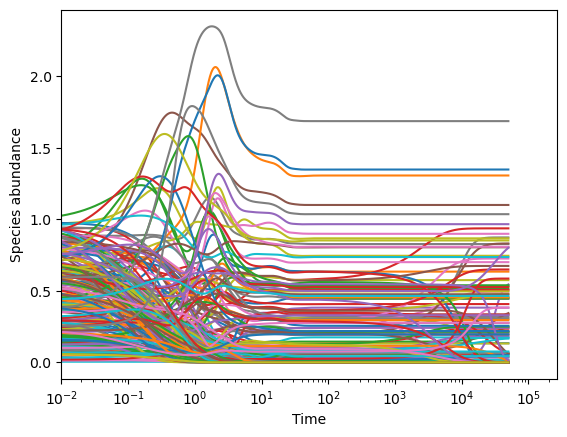

In [882]:
n_val = 200
# eq = RandomLotkaVolterra(n_val, sigma=2.0, d=2.5, kfrac=0.2, eps=0.01, random_state=0, connectivity=0.01)
# eq = RandomLotkaVolterra(n_val, sigma=2.0, d=4.5, kfrac=0.2, eps=0.001, random_state=0, connectivity=0.01)
eq = RandomLotkaVolterra(n_val, sigma=2.0, d=4.5, kfrac=0.2, eps=0.00005, random_state=0, connectivity=0.05)

# eq = RandomLotkaVolterra(n_val, sigma=2.0, d=4.5, kfrac=0.2 * 0, eps=0.001, random_state=0, connectivity=0.01)

np.random.seed(0)
ic = np.random.uniform(size=eq.n)


tlim = (0, 50000)
fsol = solve_ivp(eq, tlim, ic[:n_val], jac=eq.jac, **eq.integrator_args)
t, y = eq.integrate(tmax, ic)

sol_final = fsol.y[:, -1]
jac_final = eq.jac(0, sol_final)
eigs = np.linalg.eigvals(jac_final)
print(f"Stability observed (numerical): {np.all(np.real(eigs) < 0)}")

plt.figure()
plt.semilogx(fsol.t, fsol.y.T);
plt.xlabel("Time")
plt.ylabel("Species abundance")
plt.xlim(1e-2, None)



In [825]:
n1_val = np.linspace(0, 1, 100)
n1_val = np.linspace(0.2, 0.3, 100)
n1_val = np.linspace(0.2, 0.21, 100)
icp = ic.copy()
all_sol = []
for i, n1 in enumerate(n1_val):
    progress_bar(i, len(n1_val))
    icp[0] = n1
    t, y = eq.integrate(tmax, icp)
    all_sol.append([y, t])



    


[################### ] 



In [891]:
U, S, V = np.linalg.svd(eq.A)
# P = U[:, :10].T
# P1 = U[:, -10:].T
P_fast, P_slow = V[:10, :], V[-10:, :]
# P_slow = P_slow.T
def instantaneous_fli(y, t, dt, jac):
    
    # P2 = P_slow @ jac(t, y) @ P_slow.T

    # # ## Finite difference approximation of Jacobian
    eps = 1e-8
    jac_fd = np.zeros((P_slow.shape[0], P_slow.shape[0]))
    for i in range(jac_fd.shape[0]):
        pt0, pt1 = y.copy(), y.copy()
        pt1[i] += eps
        jac_fd[:, i] = (P_slow @ (eq(0, pt1) - eq(0, pt0))) / (P_slow @ (pt1 - pt0))
        # jac_fd[:, i] = (P_fast @ (eq(0, pt1) - eq(0, pt0))) / (P_fast @ (pt1 - pt0))
    jac_fd = np.array(jac_fd)
    P2 = jac_fd

    # Finite‐difference reduction:
    
    # eps = 1e-8
    # n_slow = P_slow.shape[1]   # should be 10
    # J_reduced_fd = np.zeros((n_slow, n_slow))
    # f0 = eq(0, y)  # baseline 100‐vector
    # for j in range(n_slow):
    #     p_j = P_slow[:, j]              # 100‐vector (slow direction j)
    #     y_perturbed = y + eps * p_j     # perturb along the jth slow basis
    #     f1 = eq(0, y_perturbed)         # 100‐vector
    #     # directional derivative of f in direction p_j:
    #     df_dp = (f1 - f0) / eps         # 100‐vector ≈ J_full @ p_j
    #     # project onto slow‐coordinates on the left:
    #     J_reduced_fd[:, j] = P_slow.T @ df_dp   # 10‐vector
    # P2 = J_reduced_fd

    # Let U[k, :] be the k-th slow‐mode represented as a 100‐vector.
    # U = P_slow.T       # shape (10, 100)
    # U = P_slow.T
    # J_full = jac(t, y)
    # # print(J_full.shape, U.shape)
    # # Preallocate the “scaled‐projection” matrix:
    # #   jac_fd[k, j] = (U[k, :] · (J_full[:, j])) / U[k, j]
    # n_modes, dim = U.shape
    # jac_fd  = np.zeros((n_modes, dim))

    # numerator = U @ J_full  # (10, 100)
    # # We only need the first n_modes columns (j=0..n_modes-1) to match the original FD over 10 coordinates.
    # # Denominator = U[:, :n_modes] (shape: 10 × 10)
    # num_slice = numerator[:, :n_modes]  # (10, 10)
    # den_slice = U[:, :n_modes]       # (10, 10)
    # # Compute jac_fd[k, j] = (u_k^T · (J_full · e_j)) / u_{k,j} for j=0..n_modes-1
    # jac_fd = num_slice / den_slice  # shape: (10, 10)
    # P2 = jac_fd

    

    Q = np.linalg.inv(np.eye(P2.shape[0]) - dt * P2)
    eigenvalues = np.linalg.eigvalsh(Q.T @ Q)
    fli_val = np.sqrt(np.max(eigenvalues))
    return fli_val


def find_fli(sol, tvals, jac):
    dtvals = np.diff(tvals)
    dtvals = np.hstack([dtvals, dtvals[-1]])
    fli = -np.inf
    for yval, dt, tval in zip(sol, dtvals, tvals):
        fli = max(fli, instantaneous_fli(yval, tval, dt, jac))
    return fli

all_fli = []
for sol, tvals in all_sol:
    all_fli.append(find_fli(sol, tvals, eq.jac))

plt.plot(n1_val, all_fli);


KeyboardInterrupt: 

In [892]:
# n_res = 120
# n_res = 100
# n_res = 10
n_res = 10
# n_res = 10
# n_res = 25
# n_res = 10
# n_res = 5
# x = np.linspace(0.2, 0.202, n_res)
# y = np.linspace(0.2, 0.202, n_res)
x = np.linspace(0.2, 0.3, n_res)
y = np.linspace(0.2, 0.3, n_res)
x = np.linspace(0.0, 1.0, n_res)
y = np.linspace(0.0, 1.0, n_res)
xx, yy = np.meshgrid(x, y)
xx, yy = xx.ravel(), yy.ravel()
pts = np.vstack([xx, yy]).T

## Fixed disorder in initial conditions
np.random.seed(0)
# ic0 = np.random.uniform(size=eq.n)
icax = np.random.uniform(size=eq.n) * np.max(sol_final)
icbx = np.random.uniform(size=eq.n) * np.max(sol_final)
icay = np.random.uniform(size=eq.n) * np.max(sol_final)
icby = np.random.uniform(size=eq.n) * np.max(sol_final)



all_fli = []
for i, ic_val in enumerate(pts):
    progress_bar(i, len(pts))
    ic = bilinear_interpolation(icax, icbx, icay, icby, ic_val[0], ic_val[1])
    ic[ic < 0] = 0.0
    # print(ic[0])
    t, y = eq.integrate(tmax, ic, tolerance=1e-10)
    fli = find_fli(y, t, eq.jac)
    all_fli.append(fli)
    

[################### ] 



(np.float64(-0.05), np.float64(1.05), np.float64(-0.05), np.float64(1.05))

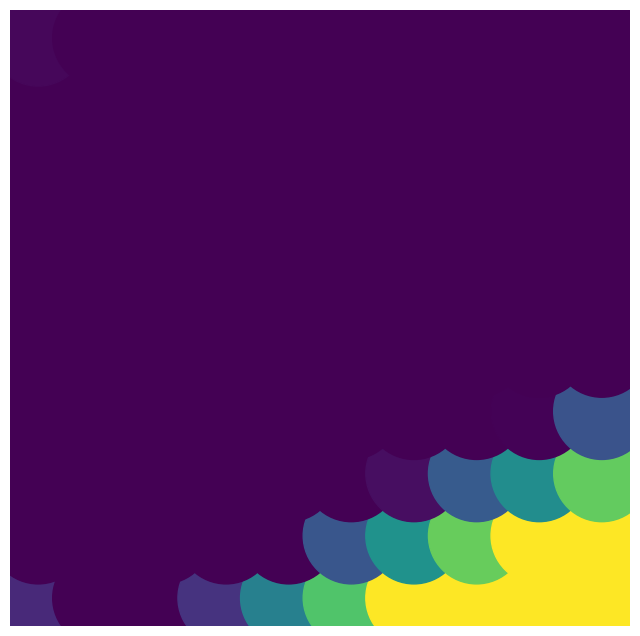

In [889]:
ms = 1200 * (20 / n_res)**2
plt.figure(figsize=(8,8))
all_fli = np.array(all_fli).astype(float)
vmin = np.percentile(all_fli, 5)
vmax = np.percentile(all_fli, 95)
plt.scatter(pts[:, 0], pts[:, 1], c=all_fli, s=ms, vmin=vmin, vmax=vmax)
# plt.colorbar()
plt.axis("off")

(np.float64(-0.05), np.float64(1.05), np.float64(-0.05), np.float64(1.05))

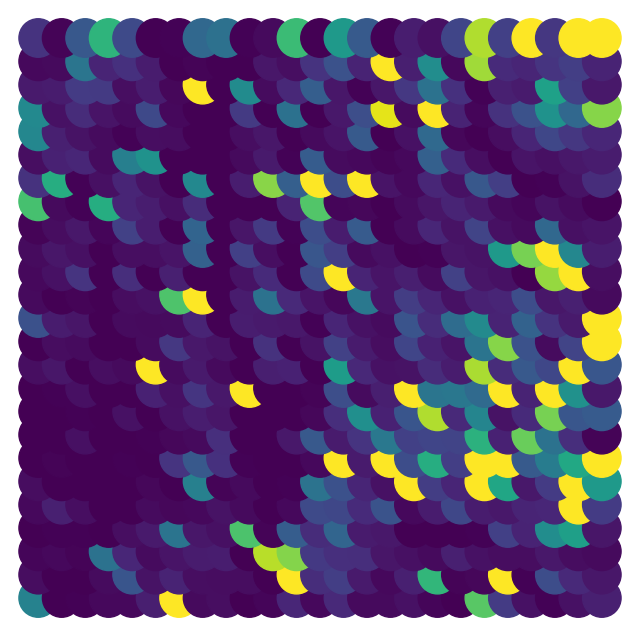

In [854]:
def bilinear_interpolation(xa, xb, ya, yb, s, t):
    """
    Perform bilinear interpolation on a grid of points.

    Args:
        xa (np.ndarray): x-coordinates of the lower left corner of the grid
        xb (np.ndarray): x-coordinates of the lower right corner of the grid
        ya (np.ndarray): y-coordinates of the lower left corner of the grid
        yb (np.ndarray): y-coordinates of the upper left corner of the grid
        s (float): Value between 0 and 1 for the x-coordinate
        t (float): Value between 0 and 1 for the y-coordinate

    Returns:
        The interpolated value
    """
    P1 = s * xa + (1 - s) * xb
    P2 = s * ya + (1 - s) * yb
    return t * P1 + (1 - t) * P2


In [ ]:
plt.plot(n1_val, all_fli);

In [ ]:
    for pt, dt, tval in zip(fsol.y.T, dtvals, fsol.t):
        
        ## Finite difference approximation of Jacobian
        eps = 1e-8
        jac_fd = np.zeros((P_slow.shape[0], P_slow.shape[0]))
        for i in range(jac_fd.shape[0]):
            pt0 = pt.copy()
            pt1 = pt.copy()
            pt1[i] += eps
            # jac_fd[:, i] = (P_slow @ (eq(0, pt1) - eq(0, pt0))) / (P_slow @ (pt1 - pt0))
            jac_fd[:, i] = (P_fast @ (eq(0, pt1) - eq(0, pt0))) / (P_fast @ (pt1 - pt0))
        jac_fd = np.array(jac_fd)
        P2 = jac_fd

        # P2 = eq.jac(tval, pt)

        Q = np.linalg.inv(np.eye(P2.shape[0]) - dt * P2)
        eigenvalues = np.linalg.eigvalsh(Q.T @ Q)
        fli_val = np.sqrt(np.max(eigenvalues))

        fli = max(fli, fli_val)

    # project onto slow subspace
    sol = P_fast @ fsol.y

In [ ]:
## Parallelize basin calc

from concurrent.futures import ProcessPoolExecutor
import multiprocessing




# n_res = 120
# n_res = 100
# n_res = 10
n_res = 50
# n_res = 10
# n_res = 25
# n_res = 10
# n_res = 5
# x = np.linspace(0.2, 0.202, n_res)
# y = np.linspace(0.2, 0.202, n_res)
x = np.linspace(0.2, 0.3, n_res)
y = np.linspace(0.2, 0.3, n_res)
x = np.linspace(0.0, 1.0, n_res)
y = np.linspace(0.0, 1.0, n_res)
xx, yy = np.meshgrid(x, y)
xx, yy = xx.ravel(), yy.ravel()
pts = np.vstack([xx, yy]).T

## Fixed disorder in initial conditions
np.random.seed(0)
# ic0 = np.random.uniform(size=eq.n)
icax = np.random.uniform(size=eq.n) * np.max(sol_final)
icbx = np.random.uniform(size=eq.n) * np.max(sol_final)
icay = np.random.uniform(size=eq.n) * np.max(sol_final)
icby = np.random.uniform(size=eq.n) * np.max(sol_final)

def process_point(ic_val):
    ic = bilinear_interpolation(icax, icbx, icay, icby, ic_val[0], ic_val[1])
    ic[ic < 0] = 0.0

    fsol = solve_ivp(eq, tlim, ic[:n_val], jac=eq.jac, **eq.integrator_args)

    sol = fsol.y
    velocities = np.array([eq(0, pt) for pt in sol.T])

    U, S, V = np.linalg.svd(eq.A)
    # P = U[:, :10].T
    # P1 = U[:, -10:].T
    P_fast, P_slow = V[:10, :], V[-10:, :]

    ## Compute fast Lyapunov indicator
    # w = np.eye(sol.shape[0])
    w = np.eye(P_slow.shape[0])
    fli = -np.inf
    dtvals = np.diff(fsol.t)
    dtvals = np.hstack([dtvals, dtvals[-1]])
    for pt, dt, tval in zip(fsol.y.T, dtvals, fsol.t):
        
        ## Finite difference approximation of Jacobian
        eps = 1e-8
        jac_fd = np.zeros((P_slow.shape[0], P_slow.shape[0]))
        for i in range(jac_fd.shape[0]):
            pt0 = pt.copy()
            pt1 = pt.copy()
            pt1[i] += eps
            # jac_fd[:, i] = (P_slow @ (eq(0, pt1) - eq(0, pt0))) / (P_slow @ (pt1 - pt0))
            jac_fd[:, i] = (P_fast @ (eq(0, pt1) - eq(0, pt0))) / (P_fast @ (pt1 - pt0))
        jac_fd = np.array(jac_fd)
        P2 = jac_fd

        # P2 = eq.jac(tval, pt)

        Q = np.linalg.inv(np.eye(P2.shape[0]) - dt * P2)
        eigenvalues = np.linalg.eigvalsh(Q.T @ Q)
        fli_val = np.sqrt(np.max(eigenvalues))

        fli = max(fli, fli_val)

    # project onto slow subspace
    sol = P_fast @ fsol.y

    ## Detect scrambles
    # zero_crossings = np.sum(np.abs(np.diff(np.sign(sol.T), axis=0))) / eq.n
    speeds = np.linalg.norm(velocities, axis=1)
    changes = np.diff(np.sign(np.diff(speeds)))
    turnaround_inds = np.where(np.abs(changes) > 0)[0]
    zero_crossings = len(turnaround_inds)

    ## Calculate alternative stopping criteria
    normvals = np.linalg.norm(sol - sol[:, -1:], axis=0) / np.linalg.norm(sol, axis=0)
    stop_ind = np.min(np.where(normvals < 1e-5)[0])
    # all_sol_dur.append(fsol.t[stop_ind])

    # all_sol_tlen.append(fsol.t[-1])
    # all_sol_var.append(np.var(sol[:, -1]))
    # all_sol_crossings.append(zero_crossings)
    # all_sol_perms.append(len(detect_permutations(sol.T)))
    # all_sol_perms.append(num_permutations(sol.T))
    final_abundances = fsol.y[:, -1]
    # all_final_sols.append(final_abundances)

    return zero_crossings, fsol.t[stop_ind], fsol.t[-1], num_permutations(sol.T), final_abundances, fli


## Serial calculation
results = list()
for i, ic_val in enumerate(pts):
    if i % (pts.shape[0] // 20) == 0:
        print(i, flush=True)
    results.append(process_point(ic_val))

## Parallel calculation
# if __name__ == '__main__':
#     # Create a pool of workers
#     with multiprocessing.Pool() as pool:
#         # Map the function over the points
#         results = pool.map(process_point, pts)

all_sol_crossings, all_sol_dur, all_sol_time, all_sol_perms, all_final_sols, all_fli = np.array(results, dtype=object).T

# Dimensionality reduction as preconditioning

+ What if we project the dynamics into a lower-dimensional space?

+ Singular value decomposition isolates fast and slow dynamics in a linear dynamical system


In [ ]:
## Picture

In [ ]:
n_val = 200
eq = RandomLotkaVolterra(200, random_state=0)

np.random.seed(0)
ic = np.random.uniform(size=eq.n)
# tlim = (0, 50000)
# fsol = solve_ivp(eq, tlim, ic[:n_val], jac=eq.jac, **eq.integrator_args)
t, y = eq.integrate(tmax, ic)

sol_final = fsol.y[:, -1]
jac_final = eq.jac(0, sol_final)
eigs = np.linalg.eigvals(jac_final)
print(f"Stability observed (numerical): {np.all(np.real(eigs) < 0)}")

plt.figure()
plt.semilogx(fsol.t, fsol.y.T);
plt.xlabel("Time")
plt.ylabel("Species abundance")
plt.xlim(1e-2, None)


ValueError: incompatible array sizes for np.dot(a, b) (matrix * vector)

The condition number alternatively can be expressed as the ratio of the largest and smallest singular values of the matrix.

$$
    \text{cond}(A) = \frac{\sigma_{\text{max}}(A)}{\sigma_{\text{min}}(A)}
$$

In [880]:
## Calculate condition number using the norm
print(np.linalg.cond(eq.A))

## Calculate condition number using SVD
U, S, V = np.linalg.svd(eq.A)
print(np.max(S) / np.min(S))

723977.2579730955
723977.2579730952


In [ ]:
def condition_number(A):
    return np.linalg.norm(A, 2) * np.linalg.norm(np.linalg.inv(A), 2)

print(condition_number(eq.A))

723977.2579730952




## The ill-conditioned Lotka-Volterra model

We consider random ecosystems given by the generalized Lotka-Volterra equation,

$$
    \frac{dN_i}{dt} = N_i \left( r_i + \sum_{j=1}^N A_{ij} N_j \right)
$$

where $N_i$ is the population of species $i$, $r_i$ is the intrinsic growth rate of species $i$, and $A_{ij}$ is the interaction coefficient between species $i$ and $j$. The steady-state solutions of this equation has the form

$$
    -A \mathbf{N}^* = \mathbf{r}
$$

where $N_i \geq 0$ for all $i$.

In this notebook, we explore the behavior of this model when the interaction matrix $A_{ij}$, and the growth rates $r_i$ are drawn from random distributions. Specifically, we consider the case where $r_i \sim \mathcal{N}(0,1)$, and the matrix $A$ has the form

$$
    A = P^\top (Q - d\, I) P + \epsilon E
$$

where $Q_{ij} \sim \mathcal{N}(0,1)$, $E_{ij} \sim \mathcal{N}(0,1)$, $P$ is a low-rank matrix imposing functional redundancy, $d$ is a constant density-limitation, and $\epsilon \ll 1$ is a small constant.


Numerical stability observed: True


Text(0.5, 1.0, 'Eigenvalues of Jacobian')

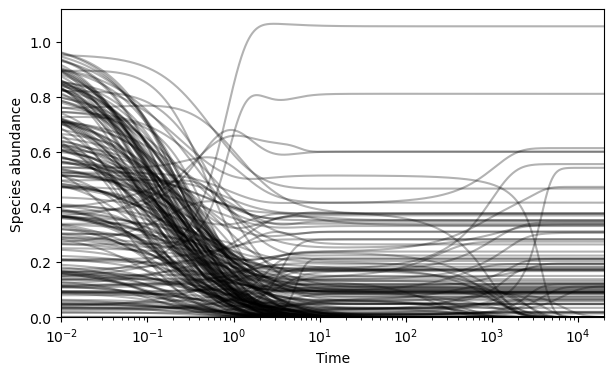

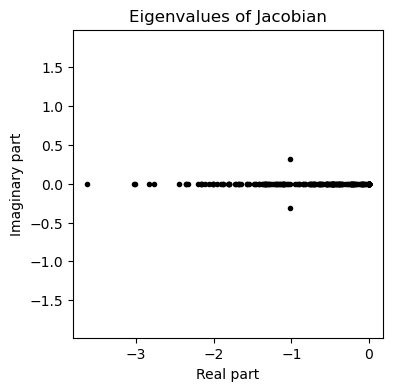

In [8]:
from scipy.integrate import solve_ivp

## Load local functions
import sys
import base
import utils
from base import RandomLotkaVolterra
from utils import levenshtein


tlim = (0, 20000) # Integration interval
n_val = 200 # Number of species

## Initialize the model
eq = RandomLotkaVolterra(n_val, sigma=2.0, d=4.5, kfrac=0.2, eps=0.001, random_state=0, connectivity=0.01)

## Initial conditions
ic = np.random.uniform(size=eq.n)

## Numerical integration
fsol = solve_ivp(eq, tlim, ic[:n_val], jac=eq.jac, **eq.integrator_args)


## Check that the found solution is stable
sol_final = fsol.y[:, -1]
jac_final = eq.jac(0, sol_final)
eigs = np.linalg.eigvals(jac_final)
print(f"Numerical stability observed: {np.all(np.real(eigs) < 0)}")

## Plot the solution
plt.figure(figsize=(7, 4))
plt.semilogx(fsol.t, fsol.y.T, color="k", lw=1.5, alpha=0.3);
plt.xlabel("Time")
plt.ylabel("Species abundance")
plt.xlim(1e-2, np.max(fsol.t))
plt.ylim(0, None)

eigvals = np.linalg.eigvals(jac_final)
plt.figure(figsize=(4, 4))
plt.plot(np.real(eigvals), np.imag(eigvals), '.k')
plt.xlabel("Real part")
plt.ylabel("Imaginary part")
plt.axis("equal")
plt.title("Eigenvalues of Jacobian")

## Dimensionality reduction as preconditioning

Original condition number:  723977.2579774971
Fast condition number:  1.8180378841429419
Slow condition number:  3.1628804216115274


(0.01, 20000.0)

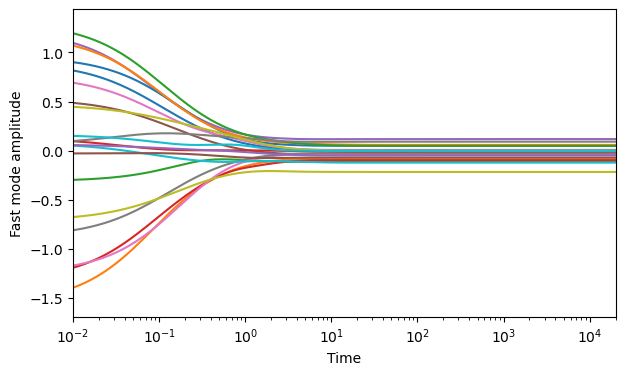

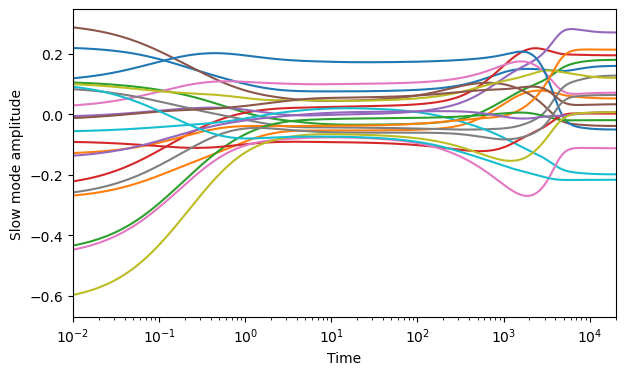

In [21]:
## Separate timescales

print("Original condition number: ", np.linalg.cond(eq.A))




U, S, V = np.linalg.svd(eq.A)
P_fast, P_slow = V[:20, :], V[-20:, :]
yp_fast = P_fast @ fsol.y # First k modes
yp_slow = P_slow @ fsol.y # Last k modes

print("Fast condition number: ", np.linalg.cond(P_fast @ eq.A))
print("Slow condition number: ", np.linalg.cond(P_slow @ eq.A))


plt.figure(figsize=(7, 4))
plt.semilogx(fsol.t, yp_fast.T);
plt.xlabel("Time")
plt.ylabel("Fast mode amplitude")
plt.xlim(1e-2, np.max(fsol.t))
# dg.better_savefig("lv_traj_fast_dark.png", dpi=600)

plt.figure(figsize=(7, 4))
plt.semilogx(fsol.t, yp_slow.T);
plt.xlabel("Time")
plt.ylabel("Slow mode amplitude")
plt.xlim(1e-2, np.max(fsol.t))
# dg.better_savefig("lv_traj_slow_dark.png", dpi=600)

